Crystal Segmentation
====================

This is a test of tools to compute the properties of the interface between the liquid and the crystal.
Since I am interested in the melting rate of a sample surrounded by liquid,
as the blob melts the surface area is going to change.
This means that I will require a normalisation factor to be able to properly compute this melting. 

In [1]:
import numpy as np
import sklearn
import sklearn.cluster
import scipy
import joblib
from sdanalysis.order import compute_neighbours, relative_orientations, relative_distances, compute_ml_order
from sdanalysis.figures import plot_frame

import warnings
warnings.filterwarnings('ignore')

# Import project tools
import sys
sys.path.append('../src')
from detection import read_all_files, neighbour_connectivity

# Configure Bokeh to output the figures to the notebook
from bokeh.io import output_notebook, show
output_notebook()

Loading BokehJS ...

This creates a periodic distance algorithm using the minimum image convention
which can be used as the distance metric for the clustering algorithm. 

In [2]:
input_files = read_all_files(
    '../data/simulations/dataset/output'
)
len(input_files)

39

In [3]:
snapshot, *_ = input_files[12]
model = joblib.load('../models/knn-trimer.pkl')
ordering = compute_ml_order(
    model, 
    snapshot.box, 
    snapshot.position, 
    snapshot.orientation,
)
ordering = ordering > 0
ordering = ordering.reshape(-1,1)

In [4]:
connectivity = neighbour_connectivity(snapshot)
spatial_cluster = sklearn.cluster.AgglomerativeClustering(n_clusters=2, connectivity=connectivity)
y = spatial_cluster.fit_predict(ordering)

In [5]:
hull = scipy.spatial.ConvexHull(snapshot.position[y==1, :2])

In [6]:
hull.area

566.4334898381048

In [7]:
show(plot_frame(snapshot, order_list=ordering.flatten()))

## Stability

In [8]:
import gsd.hoomd
from sdanalysis import HoomdFrame
from detection import spatial_clustering
test_file = '../data/simulations/dataset/output/dump-Trimer-P1.00-T0.50-p2.gsd'
cluster_size = []
cluster_area = []
with gsd.hoomd.open(test_file) as trj:
    for index, snap in enumerate(trj):
        snapshot = HoomdFrame(snap)
        clusters = spatial_clustering(snapshot)
        cluster_size.append(np.sum(clusters))
        hull1 = scipy.spatial.ConvexHull(snapshot.position[y==1, :2])
        hull0 = scipy.spatial.ConvexHull(snapshot.position[y==0, :2])
        cluster_area.append(min(hull0.volume, hull1.volume))
        if len(cluster_size) > 100:
            break

In [14]:
with gsd.hoomd.open(test_file) as trj:
    snapshot = HoomdFrame(trj[7])
    clusters = spatial_clustering(snapshot)
    show(plot_frame(snapshot, order_list=clusters))

In [10]:
import matplotlib.pyplot as plt

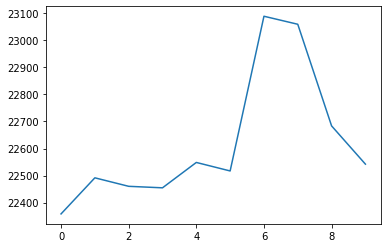

In [11]:
# plt.plot(cluster_size)
plt.plot(cluster_area);